In [5]:
import pandas as pd
import numpy as np

# 데이터 로딩
df = pd.read_csv("/content/drive/MyDrive/기계학습/r25_freq_total.csv")

# 사용할 feature 선택
feature_cols = [
    col for col in df.columns
    if any(key in col for key in [
        '_std', '_range', 'emotion_entropy',
        'mean_emotion_diff', 'pos_neg_ratio',
        'polarity_switches'
    ])
]

X = df[feature_cols]
y = df['labels']  # 0: 사람, 1: AI

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
!pip install xgboost

In [4]:
# 라벨 비율 확인 (정수 개수)
label_counts = df['labels'].value_counts()
print("🔢 정수 개수:\n", label_counts)

# 라벨 비율 확인 (비율)
label_ratio = df['labels'].value_counts(normalize=True)
print("\n📊 비율 (소수점 6자리):\n", label_ratio)

🔢 정수 개수:
 labels
0    100127
1     98649
Name: count, dtype: int64

📊 비율 (소수점 6자리):
 labels
0    0.503718
1    0.496282
Name: proportion, dtype: float64


In [5]:
!pip install shap

In [6]:
# 문자열이지만 리스트처럼 보이는 컬럼 확인
# for col in X.columns:
#     if X[col].apply(lambda x: isinstance(x, str) and x.strip().startswith('[')).any():
#         print(f"문제 있는 컬럼: {col}")
#         print(X[col].iloc[0])

삭제된 문제 컬럼들: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

=== LogisticRegression ===
Accuracy: 0.89209
Classification Report:
               precision    recall  f1-score   support

           0    0.88254   0.90642   0.89432     20026
           1    0.90233   0.87755   0.88977     19730

    accuracy                        0.89209     39756
   macro avg    0.89244   0.89198   0.89204     39756
weighted avg    0.89236   0.89209   0.89206     39756



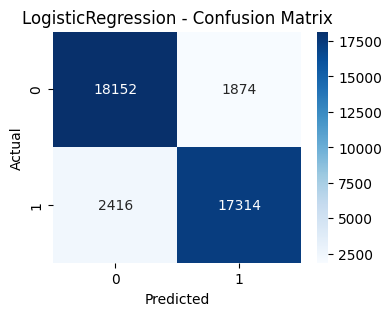


=== RandomForest ===
Accuracy: 0.94232
Classification Report:
               precision    recall  f1-score   support

           0    0.92939   0.95830   0.94363     20026
           1    0.95630   0.92610   0.94096     19730

    accuracy                        0.94232     39756
   macro avg    0.94284   0.94220   0.94229     39756
weighted avg    0.94274   0.94232   0.94230     39756



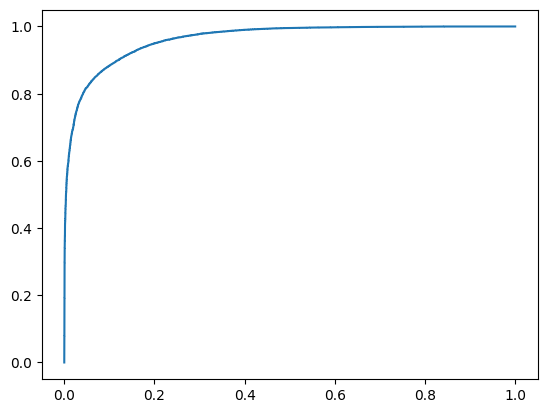

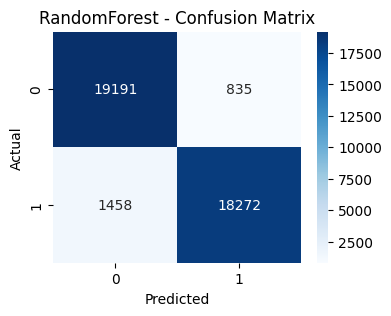


=== XGBoost ===
Accuracy: 0.94979
Classification Report:
               precision    recall  f1-score   support

           0    0.94660   0.95416   0.95036     20026
           1    0.95309   0.94536   0.94921     19730

    accuracy                        0.94979     39756
   macro avg    0.94984   0.94976   0.94979     39756
weighted avg    0.94982   0.94979   0.94979     39756



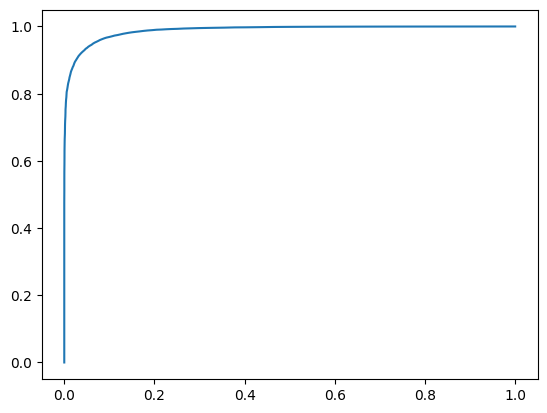

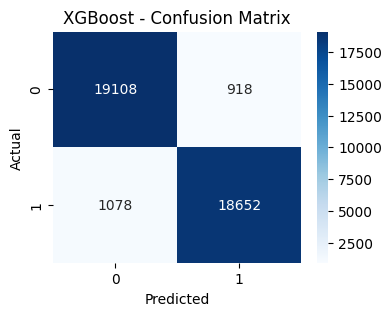

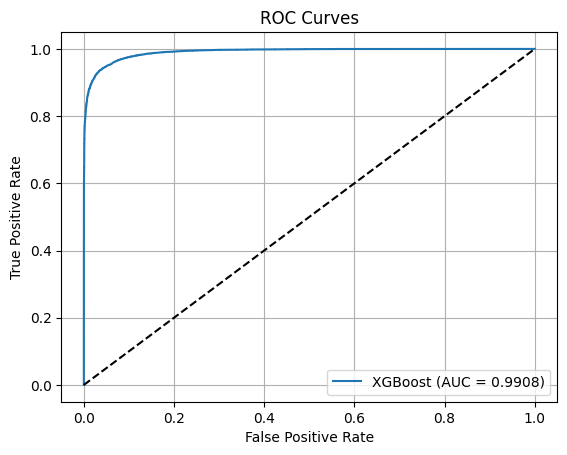

100%|===================| 39739/39756 [03:58<00:00]       

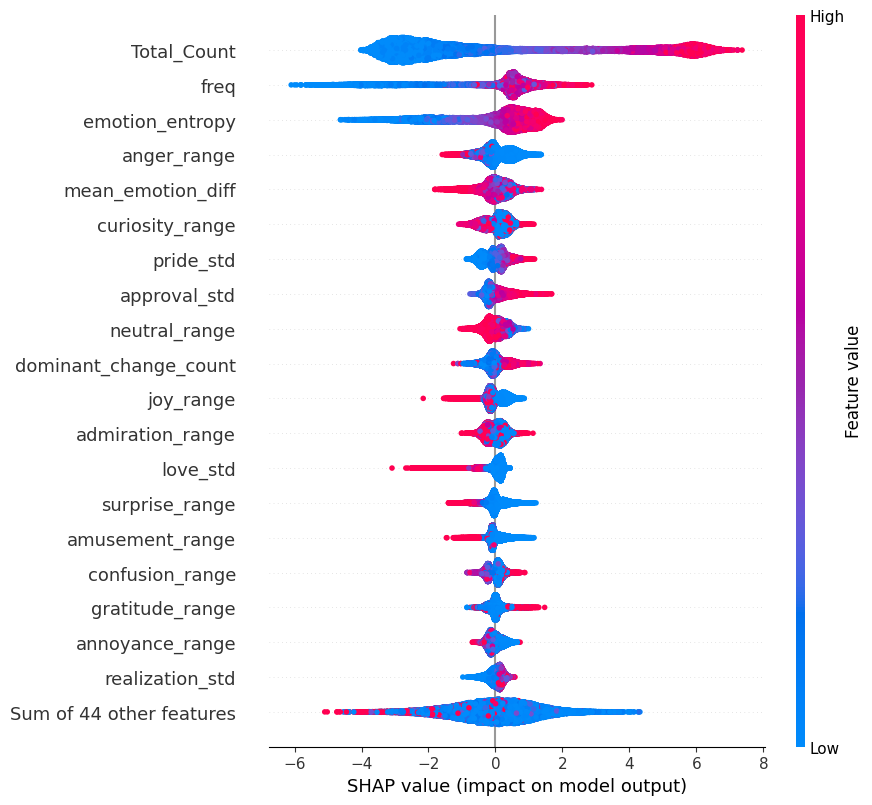

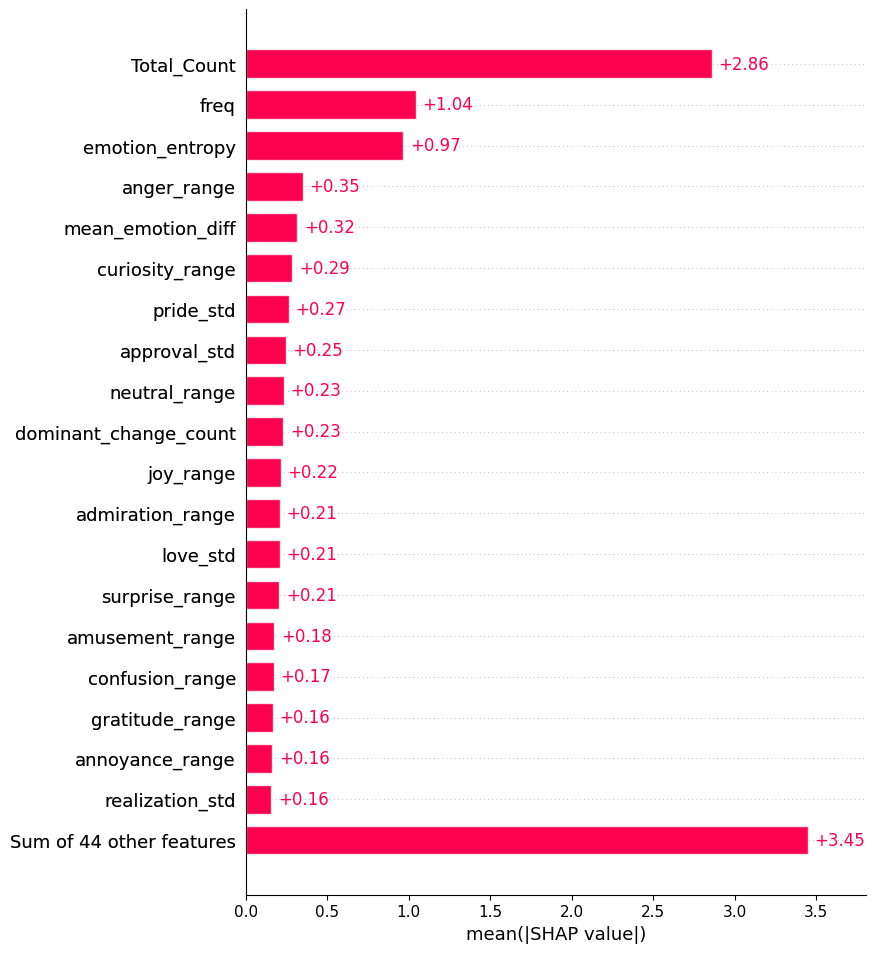

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    roc_curve, confusion_matrix
)

import shap
import warnings
warnings.filterwarnings("ignore")

# ✅ 1. 기본 설정
target_col = 'labels'
drop_cols = ['text', 'category', 'main_emotion', target_col]

# ✅ 2. feature/target 분리
X = df.drop(columns=drop_cols)
y = df[target_col]

# ✅ 3. 리스트형 문자열 컬럼 자동 감지 및 삭제
problem_cols = []
for col in X.columns:
    if X[col].apply(lambda x: isinstance(x, str) and x.strip().startswith('[')).any():
        problem_cols.append(col)

X = X.drop(columns=problem_cols)
print(f"삭제된 문제 컬럼들: {problem_cols}")

feature_names = X.columns.tolist()

# ✅ 4. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 5. 표준화 (Logistic에만 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ 6. 모델 정의
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# ✅ 7. 모델 학습 및 평가
for name, model in models.items():
    if name == "LogisticRegression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 5))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=5))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve 준비
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.4f})")

    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

# ✅ 8. ROC Curve 시각화
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

# ✅ 9. SHAP 분석 (XGBoost만)
xgb_model = results["XGBoost"]["model"]

# SHAP은 DataFrame으로 분석해야 정확함
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.Explainer(xgb_model, X_train_df)
shap_values = explainer(X_test_df)

# SHAP Beeswarm Plot
shap.plots.beeswarm(shap_values, max_display=20)

# SHAP Bar Plot
shap.plots.bar(shap_values, max_display=20)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_feature_importance(model, features, title, top_n=20):
    importance_df = None

    # RandomForest 또는 XGBoost (Sklearn 래퍼)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

        if len(importances) != len(features):
            print(f"⚠️ Warning: feature 개수({len(features)})와 importance 개수({len(importances)}) 불일치")
            min_len = min(len(importances), len(features))
            importances = importances[:min_len]
            features = features[:min_len]

        importance_df = pd.DataFrame({
            "feature": features,
            "importance": importances
        })

    # Logistic Regression
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])

        if len(importances) != len(features):
            print(f"⚠️ Warning: feature 개수({len(features)})와 coef 개수({len(importances)}) 불일치")
            min_len = min(len(importances), len(features))
            importances = importances[:min_len]
            features = features[:min_len]

        importance_df = pd.DataFrame({
            "feature": features,
            "importance": importances
        })

    # XGBoost Booster 객체 사용
    elif hasattr(model, "get_booster"):
        booster = model.get_booster()
        score = booster.get_score(importance_type='weight')  # 또는 'gain', 'cover'

        importance_df = pd.DataFrame({
            'feature': list(score.keys()),
            'importance': list(score.values())
        })

    else:
        print(f"❌ {title}: 이 모델은 feature importance를 지원하지 않음")
        return

    # 정렬 및 상위 top_n
    importance_df = importance_df.sort_values(by="importance", ascending=False).head(top_n)

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=importance_df, palette="viridis")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [19]:
# 예시 (X_train, y_train 은 당신의 학습 데이터)
models["XGBoost"].fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

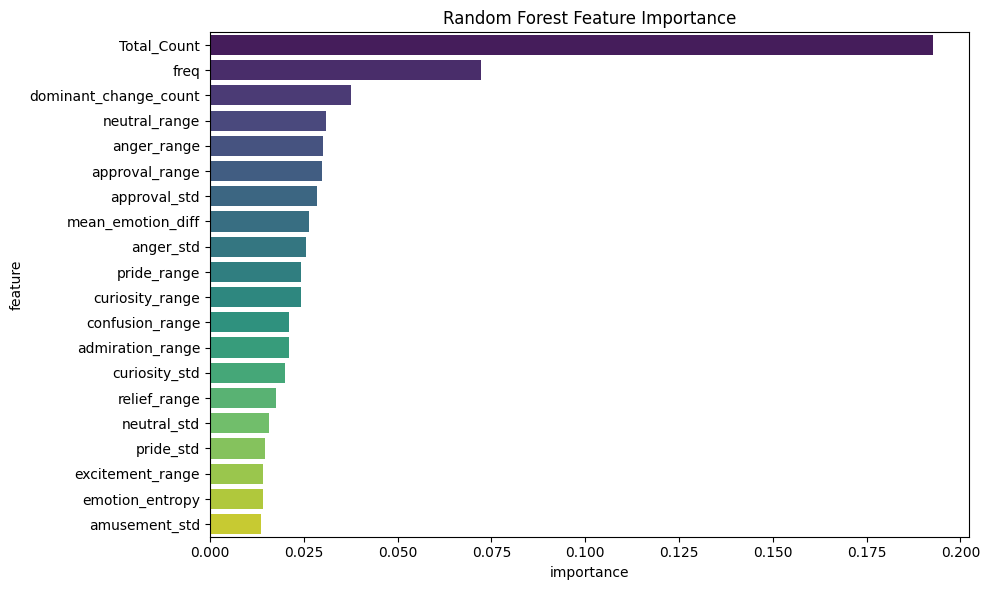

In [21]:
from sklearn.ensemble import RandomForestClassifier

# 재학습
models["Random Forest"] = RandomForestClassifier(random_state=42)
models["Random Forest"].fit(X_train, y_train)

# 시각화
plot_feature_importance(models["Random Forest"], X_train.columns.tolist(), "Random Forest Feature Importance")

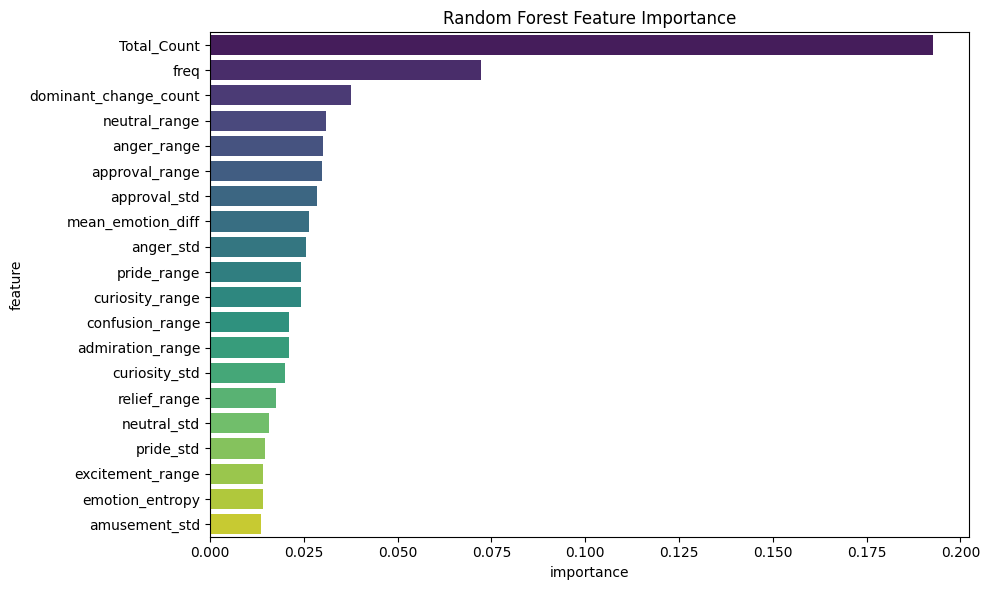

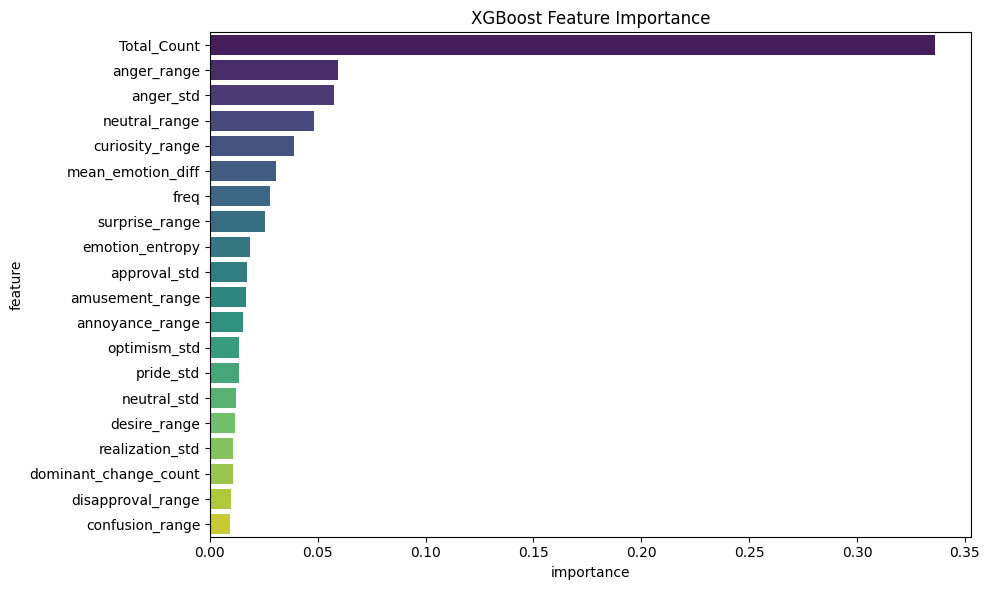

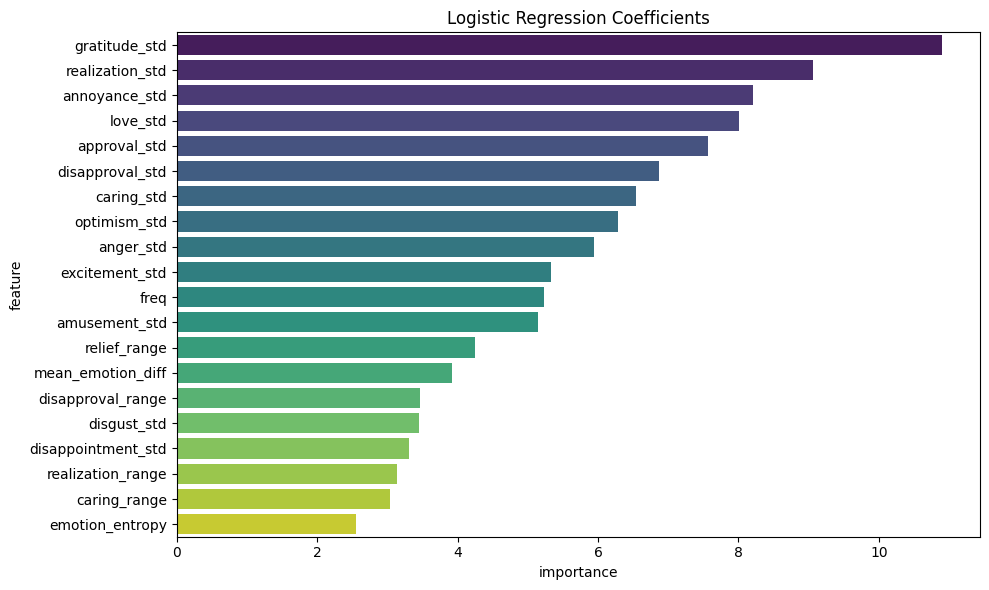

In [22]:
plot_feature_importance(models["Random Forest"], X_train.columns.tolist(), "Random Forest Feature Importance")
plot_feature_importance(models["XGBoost"], X_train.columns.tolist(), "XGBoost Feature Importance")
plot_feature_importance(models["Logistic Regression"], X_train.columns.tolist(), "Logistic Regression Coefficients")

#하이퍼파라미터튜닝

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 로지스틱 회귀

Fitting 3 folds for each of 4 candidates, totalling 12 fits

[Logistic Regression] Best Parameters:
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.8920917597343797
Classification Report:
               precision    recall  f1-score   support

           0    0.88254   0.90642   0.89432     20026
           1    0.90233   0.87755   0.88977     19730

    accuracy                        0.89209     39756
   macro avg    0.89244   0.89198   0.89204     39756
weighted avg    0.89236   0.89209   0.89206     39756



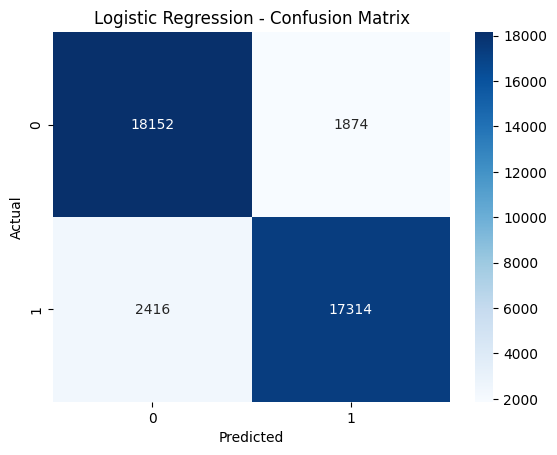

In [24]:
log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    log_params,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

log_grid.fit(X_train_scaled, y_train)

print("\n[Logistic Regression] Best Parameters:")
print(log_grid.best_params_)

y_pred_log = log_grid.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log, digits=5))

cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Random Forest

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 간소화된 파라미터
rf_params = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

# 빠른 GridSearch
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=2,                         # 줄이면 속도↑
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# 학습
rf_grid.fit(X_train, y_train)

# 결과 출력
print("\n[Random Forest] Best Parameters:")
print(rf_grid.best_params_)

y_pred_rf = rf_grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=5))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: 

# XGBoost

Fitting 3 folds for each of 16 candidates, totalling 48 fits

[XGBoost] Best Parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.9475299325887916
Classification Report:
               precision    recall  f1-score   support

           0    0.94366   0.95271   0.94817     20026
           1    0.95153   0.94227   0.94688     19730

    accuracy                        0.94753     39756
   macro avg    0.94760   0.94749   0.94752     39756
weighted avg    0.94757   0.94753   0.94753     39756



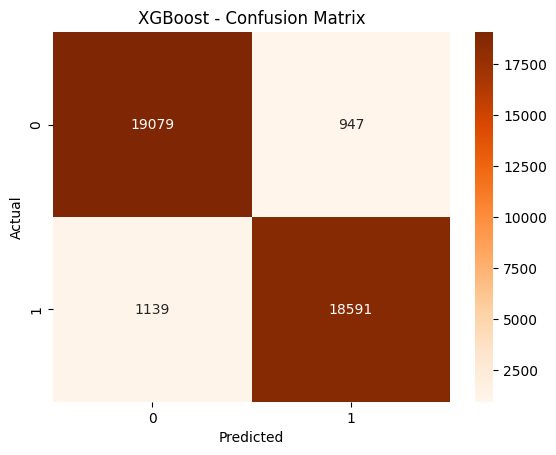

In [28]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)

xgb_grid.fit(X_train, y_train)

print("\n[XGBoost] Best Parameters:")
print(xgb_grid.best_params_)

y_pred_xgb = xgb_grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, digits=5))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# RandomizedSearchCV + XGBoost

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_rand = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=10,  # 빠른 튜닝 위해 적은 수
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_rand.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_rand.best_params_)

y_pred = xgb_rand.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score report:\n", classification_report(y_test, y_pred, digits=5))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Parameters: {'learning_rate': np.float64(0.12973169683940733), 'max_depth': 9, 'n_estimators': 221, 'subsample': np.float64(0.7467983561008608)}
Accuracy: 0.9566857832779958
F1-score report:
               precision    recall  f1-score   support

           0    0.95200   0.96255   0.95724     20026
           1    0.96155   0.95073   0.95611     19730

    accuracy                        0.95669     39756
   macro avg    0.95677   0.95664   0.95668     39756
weighted avg    0.95674   0.95669   0.95668     39756



Fitting 3 folds for each of 50 candidates, totalling 150 fits
✅ Best XGBoost Parameters: {'colsample_bytree': np.float64(0.954646859580264), 'gamma': np.float64(0.13808385936852352), 'learning_rate': np.float64(0.18365946865226762), 'max_depth': 9, 'n_estimators': 441, 'reg_alpha': np.float64(0.32815266747473193), 'reg_lambda': np.float64(0.1550416167277442), 'subsample': np.float64(0.9927363553242124)}
🎯 Accuracy: 0.957767381024248
📊 F1-score report:
               precision    recall  f1-score   support

           0    0.95380   0.96280   0.95828     20026
           1    0.96188   0.95266   0.95725     19730

    accuracy                        0.95777     39756
   macro avg    0.95784   0.95773   0.95776     39756
weighted avg    0.95781   0.95777   0.95776     39756



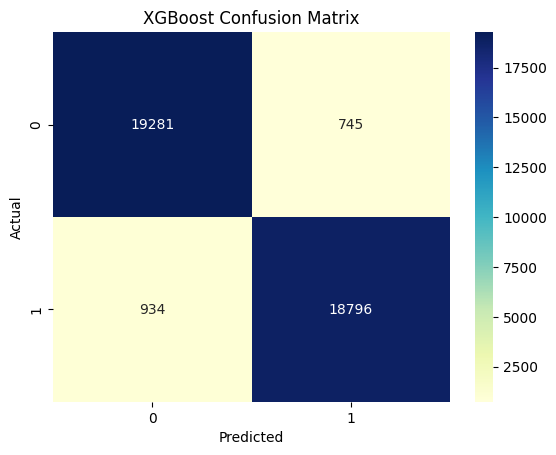

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

# 클래스 불균형 비율 계산
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale = neg / pos

# 확장된 하이퍼파라미터 공간
xgb_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

# 모델 정의
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale
)

# RandomizedSearchCV 수행
xgb_rand = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=50,  # 탐색 개수 증가
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 학습
xgb_rand.fit(X_train, y_train)

# 결과 출력
print("✅ Best XGBoost Parameters:", xgb_rand.best_params_)

y_pred = xgb_rand.predict(X_test)
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("📊 F1-score report:\n", classification_report(y_test, y_pred, digits=5))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 파생 피처 생성

In [38]:
# 감정 계열 컬럼 추출
std_cols = [col for col in df.columns if col.endswith('_std')]
range_cols = [col for col in df.columns if col.endswith('_range')]

# 파생 피처 생성
df['total_emotion_std'] = df[std_cols].sum(axis=1)
df['total_emotion_range'] = df[range_cols].sum(axis=1)
df['emotion_volatility'] = df['total_emotion_range'] / (df['total_emotion_std'] + 1e-6)
df['extreme_switch_score'] = df['emotion_entropy'] * df['polarity_switches']
df['emotional_focus'] = df['dominant_change_count'] / (df['emotion_entropy'] + 1e-6)
df['info_quality'] = 1 / (df['freq'] + df['Total_Count'] + 1)

In [39]:
# 사용할 feature column들 정의
feature_cols = std_cols + range_cols + [
    'mean_emotion_diff', 'dominant_change_count', 'emotion_entropy',
    'pos_neg_ratio', 'polarity_switches', 'freq', 'Total_Count',
    'total_emotion_std', 'total_emotion_range', 'emotion_volatility',
    'extreme_switch_score', 'emotional_focus', 'info_quality'
]

X = df[feature_cols]
y = df['labels']

# 학습/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
# 피처 수치형 변환
X = df[feature_cols].copy()
X = X.apply(pd.to_numeric, errors='coerce')  # 모든 값을 숫자로 강제
X = X.fillna(0)

# 라벨도 시리즈로 확실히 설정
y = df['labels'].squeeze()

# 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
# 컬럼 이름 강제 변환
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# y 값이 Series인지 확인
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

# XGBoost 모델 정의
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
}

xgb_rand = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 학습 시 .values로 우회
xgb_rand.fit(X_train.values, y_train.values)

# 예측
y_pred = xgb_rand.predict(X_test.values)
print("Best XGBoost Parameters:", xgb_rand.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score report:\n", classification_report(y_test, y_pred, digits=5))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Parameters: {'learning_rate': np.float64(0.12973169683940733), 'max_depth': 9, 'n_estimators': 221, 'subsample': np.float64(0.7467983561008608)}
Accuracy: 0.9576164604084918
F1-score report:
               precision    recall  f1-score   support

           0    0.95383   0.96245   0.95812     20026
           1    0.96153   0.95271   0.95710     19730

    accuracy                        0.95762     39756
   macro avg    0.95768   0.95758   0.95761     39756
weighted avg    0.95765   0.95762   0.95761     39756



# 성능 비교 후 Threshold 튜닝

In [55]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_recall_curve

# 기본 예측값 (threshold = 0.5)
y_pred_default = xgb_rand.predict(X_test.values)
print("🔹 기본 threshold (0.5) 성능")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("F1 Score:", f1_score(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default, digits=5))

🔹 기본 threshold (0.5) 성능
Accuracy: 0.9576164604084918
F1 Score: 0.9571017592097558
              precision    recall  f1-score   support

           0    0.95383   0.96245   0.95812     20026
           1    0.96153   0.95271   0.95710     19730

    accuracy                        0.95762     39756
   macro avg    0.95768   0.95758   0.95761     39756
weighted avg    0.95765   0.95762   0.95761     39756



In [56]:
import numpy as np

# 확률값 얻기
y_proba = xgb_rand.predict_proba(X_test.values)[:, 1]

# Precision-Recall curve 기반으로 최적 threshold 탐색
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # f1 계산
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"\n🔍 Best Threshold: {best_threshold:.4f}")
print(f"🔸 Best F1 Score at Threshold: {best_f1:.5f}")


🔍 Best Threshold: 0.4894
🔸 Best F1 Score at Threshold: 0.95738


In [57]:
# 최적 threshold 적용
y_pred_thresh = (y_proba >= best_threshold).astype(int)

print("\n🎯 최적 threshold 적용 후 성능")
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits=5))


🎯 최적 threshold 적용 후 성능
Accuracy: 0.9578428413321259
F1 Score: 0.9573818847581752
              precision    recall  f1-score   support

           0    0.95511   0.96150   0.95829     20026
           1    0.96066   0.95413   0.95738     19730

    accuracy                        0.95784     39756
   macro avg    0.95788   0.95782   0.95784     39756
weighted avg    0.95786   0.95784   0.95784     39756



# 모델 앙상블 or StackingClassifier 시도

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 기본 모델 구성
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('svc', SVC(probability=True, kernel='rbf', C=1.0, random_state=42))
]

# 메타 모델은 간단한 로지스틱 회귀
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=True  # base 모델의 입력 특성도 같이 전달
)

# 모델 학습
stacking_model.fit(X_train.values, y_train)

# 예측 및 평가
y_pred_stack = stacking_model.predict(X_test.values)

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("✅ [StackingClassifier] 성능")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack, digits=5))

In [4]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Base 모델: 빠르게 동작하는 모델들
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# 최종 모델: 빠르고 성능도 괜찮은 Logistic Regression
final_estimator = LogisticRegression(max_iter=500)

# Stacking 구성
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=3,
    n_jobs=-1,
    passthrough=True  # 원래 feature도 같이 사용
)

# 학습
stacking_model.fit(X_train, y_train)

# 예측
y_pred_stack = stacking_model.predict(X_test)

# 성능 평가
print("🔹 Stacking Classifier 성능 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("F1-Score:\n", classification_report(y_test, y_pred_stack, digits=5))

🔹 Stacking Classifier 성능 🔹
Accuracy: 0.8576063990341081
F1-Score:
               precision    recall  f1-score   support

           0    0.86270   0.85309   0.85787     20026
           1    0.85255   0.86219   0.85734     19730

    accuracy                        0.85761     39756
   macro avg    0.85763   0.85764   0.85761     39756
weighted avg    0.85766   0.85761   0.85761     39756



# 추가로 threshold 튜닝

In [ ]:
y_proba_stack = stacking_model.predict_proba(X_test.values)[:, 1]

# threshold 튜닝은 동일 방식 적용
from sklearn.metrics import precision_recall_curve
import numpy as np

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_stack)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]

# 최적 threshold 적용
y_pred_best = (y_proba_stack >= best_thresh).astype(int)
print(f"\n🎯 Best Threshold for Stacking: {best_thresh:.4f}")
print("New F1 Score:", f1_score(y_test, y_pred_best))

# LightGBM

In [29]:
pip install lightgbm shap

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 78919, number of negative: 80101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15403
[LightGBM] [Info] Number of data points in the train set: 159020, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496283 -> initscore=-0.014866
[LightGBM] [Info] Start training from score -0.014866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

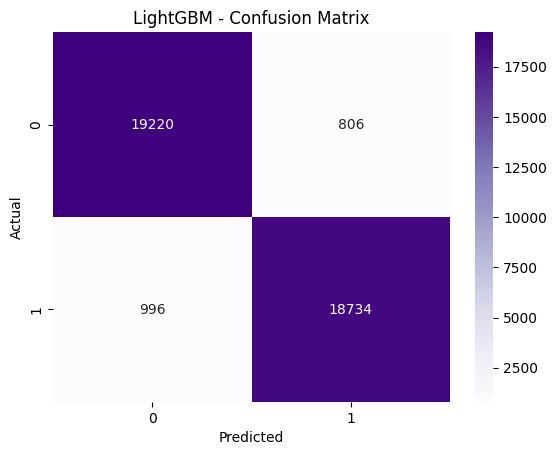

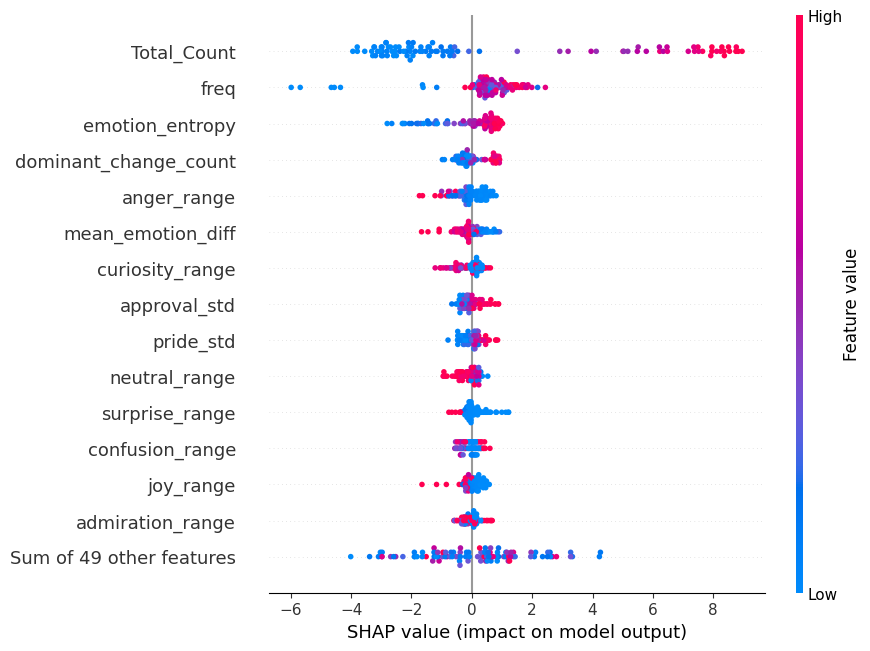

In [30]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint, uniform
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ LightGBM 기본 모델
lgb_model = lgb.LGBMClassifier(random_state=42)

# 2️⃣ 하이퍼파라미터 범위 정의 (랜덤서치용)
lgb_params = {
    'num_leaves': randint(20, 60),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 300),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# 3️⃣ RandomizedSearchCV 적용
lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_params,
    n_iter=10,  # 더 빠르게 튜닝할 수 있음
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4️⃣ 모델 학습
lgb_search.fit(X_train, y_train)

print("✅ Best Parameters:", lgb_search.best_params_)

# 5️⃣ 예측 및 평가
y_pred = lgb_search.predict(X_test)
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("🧾 Classification Report:\n", classification_report(y_test, y_pred, digits=5))

# 6️⃣ Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("LightGBM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7️⃣ SHAP 값 시각화 (LightGBM 모델로)
explainer = shap.Explainer(lgb_search.best_estimator_)
shap_values = explainer(X_test[:100])  # 너무 커지지 않도록 일부만
shap.plots.beeswarm(shap_values, max_display=15)

# 데이터갯수 확인

In [32]:
!pip install tabulate

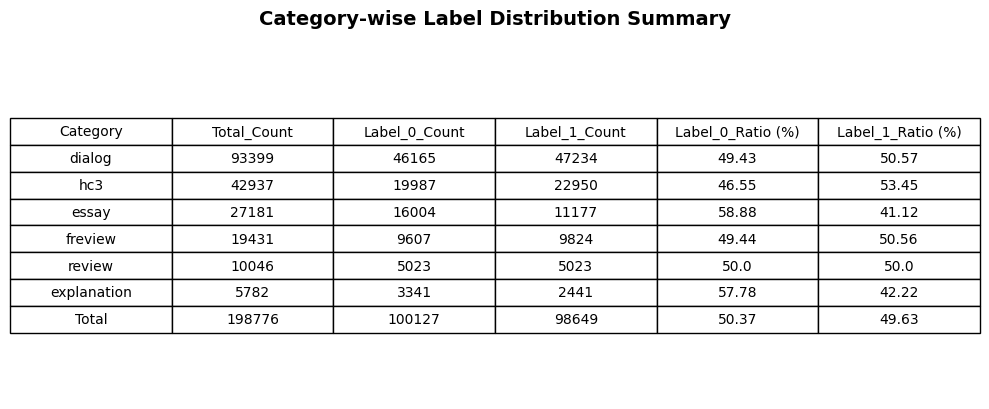

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 1. 카테고리별 전체 개수
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Total_Count']

# ✅ 2. 각 category별 label 0/1 개수
category_labels_counts = df.groupby('category')['labels'].value_counts().unstack(fill_value=0).reset_index()
category_labels_counts.columns = ['Category', 'Label_0_Count', 'Label_1_Count']

# ✅ 3. 병합 및 비율 계산
category_info = pd.merge(category_counts, category_labels_counts, on='Category')
category_info['Label_0_Ratio (%)'] = (category_info['Label_0_Count'] / category_info['Total_Count']) * 100
category_info['Label_1_Ratio (%)'] = (category_info['Label_1_Count'] / category_info['Total_Count']) * 100

# ✅ 4. 전체 요약행 추가
total_row = pd.DataFrame({
    'Category': ['Total'],
    'Total_Count': [len(df)],
    'Label_0_Count': [df['labels'].value_counts().get(0, 0)],
    'Label_1_Count': [df['labels'].value_counts().get(1, 0)],
    'Label_0_Ratio (%)': [df['labels'].value_counts(normalize=True).get(0, 0) * 100],
    'Label_1_Ratio (%)': [df['labels'].value_counts(normalize=True).get(1, 0) * 100]
})

summary_df = pd.concat([category_info, total_row], ignore_index=True)
summary_df = summary_df.round(2)

# ✅ 5. 표 형태로 시각화
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.6))
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title("Category-wise Label Distribution Summary", fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()

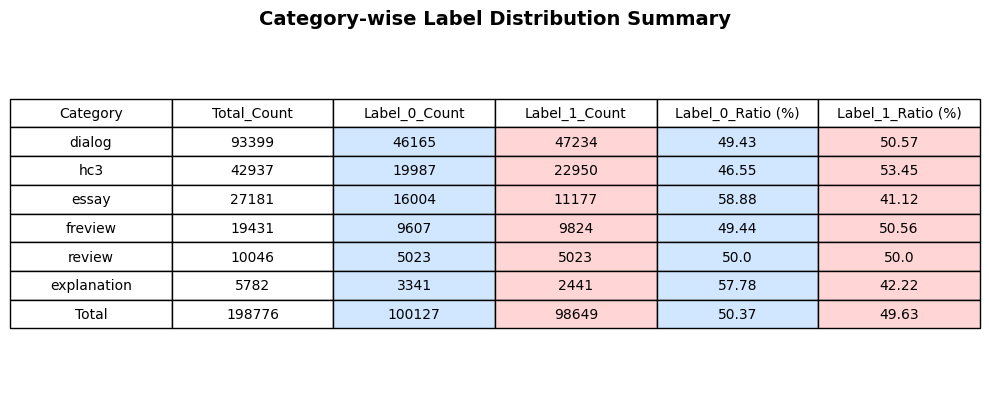

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# 색상 정의
def get_cell_colors(df):
    colors_list = []
    for row in df.itertuples(index=False):
        row_colors = []
        for i, val in enumerate(row):
            if i == 2:  # Label_0_Count
                row_colors.append('#d0e7ff')  # 파란색 톤
            elif i == 3:  # Label_1_Count
                row_colors.append('#ffd5d5')  # 빨간색 톤
            elif i == 4:  # Label_0_Ratio (%)
                row_colors.append('#d0e7ff')
            elif i == 5:  # Label_1_Ratio (%)
                row_colors.append('#ffd5d5')
            else:
                row_colors.append('#ffffff')  # 기본 흰색
        colors_list.append(row_colors)
    return colors_list

# 👇 이미 summary_df가 있다고 가정
colors = get_cell_colors(summary_df)

fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellColours=colors,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# 제목과 표 간격 줄이기
plt.subplots_adjust(top=0.85)
plt.title("Category-wise Label Distribution Summary", fontsize=14, weight='bold', pad=0.5)

plt.tight_layout()
plt.show()

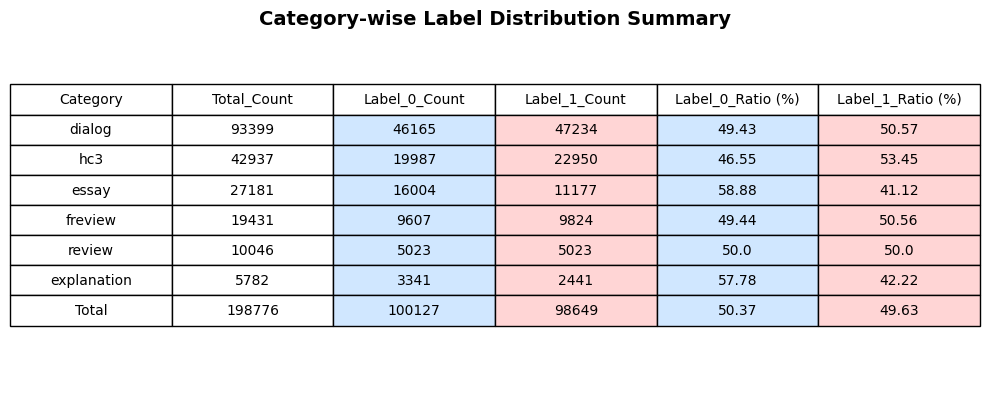

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 색상 정의 함수
def get_cell_colors(df):
    colors_list = []
    for row in df.itertuples(index=False):
        row_colors = []
        for i, val in enumerate(row):
            if i == 2:  # Label_0_Count
                row_colors.append('#d0e7ff')  # 파란색 계열
            elif i == 3:  # Label_1_Count
                row_colors.append('#ffd5d5')  # 빨간색 계열
            elif i == 4:  # Label_0_Ratio (%)
                row_colors.append('#d0e7ff')
            elif i == 5:  # Label_1_Ratio (%)
                row_colors.append('#ffd5d5')
            else:
                row_colors.append('#ffffff')  # 기본 흰색
        colors_list.append(row_colors)
    return colors_list

# 📊 테이블 시각화
colors = get_cell_colors(summary_df)

fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellColours=colors,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# 제목을 직접 그리기 (ax.text 사용 → 위치를 명확히 제어)
fig.text(0.5, 0.93, "Category-wise Label Distribution Summary", fontsize=14, weight='bold', ha='center')

plt.tight_layout()
plt.show()

In [1]:
# prompt: 한국어 사용 가능한 matploib 및 글꼴 다운로드

# 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 런타임 다시 시작 (필요시)
# import os
# os.kill(os.getpid(), 9)

# 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# 폰트 적용 확인
print ('✅ 설정 폰트:', plt.rcParams['font.family'])

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

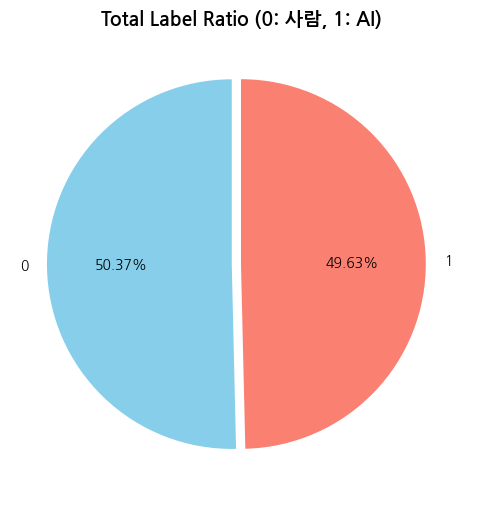

In [4]:
# prompt: total 비율을 나타내는 그래프 코드

# 라벨 비율 파이 차트 시각화
label_ratio = df['labels'].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(
    label_ratio,
    labels=label_ratio.index,
    autopct='%1.2f%%',  # 소수점 둘째 자리까지 표시
    startangle=90,
    colors=['skyblue', 'salmon'],  # 색상 지정
    explode=[0.05, 0]  # 첫 번째 조각 강조
)
plt.title("Total Label Ratio (0: 사람, 1: AI)", fontsize=14, weight='bold')
plt.show()

In [7]:
# prompt: plt다운받는 코드 작성해줘

!pip install matplotlib


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Human vs AI")
plt.show()

NameError: name 'model' is not defined

<ipython-input-11-2557985637>:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-2557985637>:28: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-2557985637>:28: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-2557985637>:28: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.1

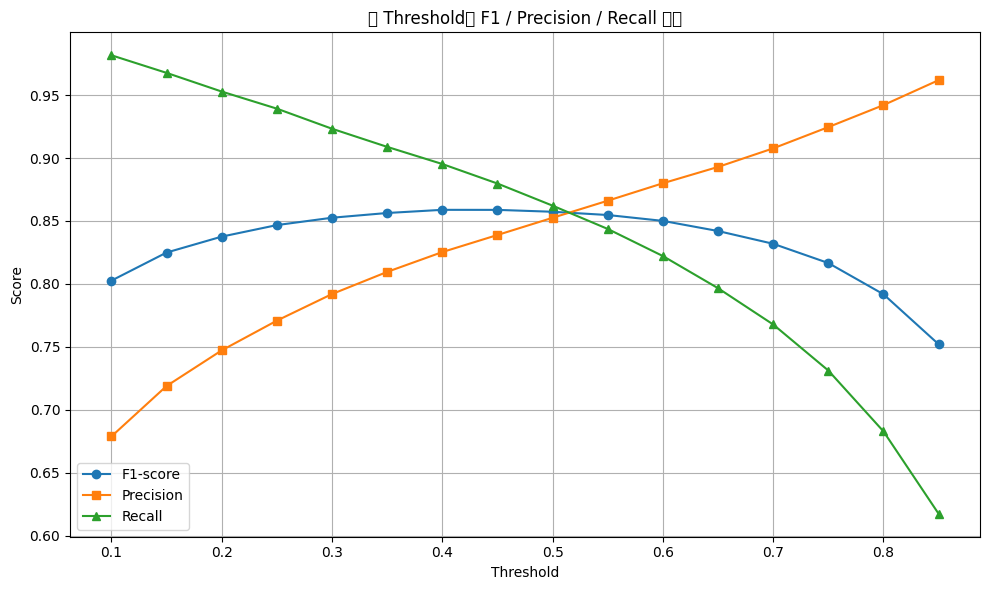

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.arange(0.1, 0.9, 0.05)
f1s = []
precisions = []
recalls = []

# 스태킹 모델 확률 예측
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_pred_thresh = (y_proba_stack >= t).astype(int)
    f1s.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="F1-score", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='s')
plt.plot(thresholds, recalls, label="Recall", marker='^')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("📈 Threshold별 F1 / Precision / Recall 변화")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()